# Week 5 GAN Project
## Introduction 
### What is a GAN?
GAN stands for Generative Adversarial Network. The gist is to have two neural networks "compete" with each other in a zero-sum game.
In our example we will be generating some fake Monet-style paintings.

The first network, the generator, takes in some input data and "forges" some fake Monet-style paintings from photos. 

The second network, the discriminator, then takes the generated images from the generator and compares it to real images to see if it can discriminate betwen real and fake. 

The generator is essentially trained to trick the discriminator, allowing the model to learn in an unsupervised manner.

# EDA
We are given 4 directories of image, monet_tfrec, photo_tfrec, monet_jpg, and photo_jpg. 

The photo directories are made up of normal photographs meant to be used in the generator model to create fake monet paintings.

The monet directories are, of course, monet paintings. Our discriminator will be using the monet paintings to cross-check the generator's generated images. 

There are 300 monet paintings and 7038 photos given in this kaggle competition.

Each photo and painting is 256x256 pixels

May the strongest survive!

In [10]:
import tensorflow as tf

gpus = tf.config.list_physical_devices('GPU')
print("GPUs available:", gpus)

GPUs available: []


# Model 

In [11]:
import tensorflow as tf
from tensorflow.keras import layers
import pathlib

IMG_SIZE = 256
BATCH_SIZE = 32

def preprocess_image(img):
    img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))
    img = (tf.cast(img, tf.float32) / 127.5) - 1  # scale to [-1,1]
    return img

# Load photos (generator input)
photos_ds = tf.keras.utils.image_dataset_from_directory(
    "C:/Users/diego/GradSchool/DeepLearningIntro/WeekFive/photo_jpg",
    label_mode=None,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE
).map(preprocess_image)

# Load Monet paintings (discriminator target)
monet_ds = tf.keras.utils.image_dataset_from_directory(
    "C:/Users/diego/GradSchool/DeepLearningIntro/WeekFive/monet_jpg",
    label_mode=None,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE
).map(preprocess_image)

Found 0 files belonging to 1 classes.


ValueError: No images found in directory C:/Users/diego/GradSchool/DeepLearningIntro/WeekFive/photo_jpg. Allowed formats: ('.bmp', '.gif', '.jpeg', '.jpg', '.png')

In [3]:
def build_generator():
    inputs = layers.Input(shape=[IMG_SIZE, IMG_SIZE, 3])

    # Encoder
    x = layers.Conv2D(64, 4, strides=2, padding="same")(inputs)
    x = layers.LeakyReLU()(x)

    # Bottleneck
    x = layers.Conv2D(128, 4, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)

    # Decoder
    x = layers.Conv2DTranspose(64, 4, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    outputs = layers.Conv2DTranspose(3, 4, strides=2, padding="same", activation="tanh")(x)

    return tf.keras.Model(inputs, outputs)

generator = build_generator()


In [4]:
def build_discriminator():
    inputs = layers.Input(shape=[IMG_SIZE, IMG_SIZE, 3])

    x = layers.Conv2D(64, 4, strides=2, padding="same")(inputs)
    x = layers.LeakyReLU()(x)

    x = layers.Conv2D(128, 4, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)

    x = layers.Conv2D(256, 4, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)

    x = layers.Conv2D(1, 4, padding="same")(x)

    return tf.keras.Model(inputs, x)

discriminator = build_discriminator()

In [14]:
loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=True)

gen_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
disc_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [6]:
@tf.function
def train_step(photo_batch, monet_batch):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        fake_monet = generator(photo_batch, training=True)

        real_output = discriminator(monet_batch, training=True)
        fake_output = discriminator(fake_monet, training=True)

        gen_loss = loss_fn(tf.ones_like(fake_output), fake_output)  # fool D
        disc_loss_real = loss_fn(tf.ones_like(real_output), real_output)
        disc_loss_fake = loss_fn(tf.zeros_like(fake_output), fake_output)
        disc_loss = (disc_loss_real + disc_loss_fake) * 0.5

    gradients_gen = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_disc = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    gen_optimizer.apply_gradients(zip(gradients_gen, generator.trainable_variables))
    disc_optimizer.apply_gradients(zip(gradients_disc, discriminator.trainable_variables))

    return gen_loss, disc_loss

In [7]:
import itertools

EPOCHS = 50

for epoch in range(EPOCHS):
    for photo_batch, monet_batch in zip(photos_ds, itertools.cycle(monet_ds)):
        gen_loss, disc_loss = train_step(photo_batch, monet_batch)

    print(f"Epoch {epoch+1}/{EPOCHS}, Gen Loss: {gen_loss.numpy():.4f}, Disc Loss: {disc_loss.numpy():.4f}")

Epoch 1/50, Gen Loss: 0.7813, Disc Loss: 0.6630
Epoch 2/50, Gen Loss: 1.0447, Disc Loss: 0.5086
Epoch 3/50, Gen Loss: 1.3295, Disc Loss: 0.3356
Epoch 4/50, Gen Loss: 1.4806, Disc Loss: 0.2976
Epoch 5/50, Gen Loss: 2.5663, Disc Loss: 0.1739
Epoch 6/50, Gen Loss: 2.2044, Disc Loss: 0.2248
Epoch 7/50, Gen Loss: 2.4347, Disc Loss: 0.2280
Epoch 8/50, Gen Loss: 2.6065, Disc Loss: 0.1962
Epoch 9/50, Gen Loss: 2.4381, Disc Loss: 0.2192
Epoch 10/50, Gen Loss: 2.3163, Disc Loss: 0.1971
Epoch 11/50, Gen Loss: 2.2751, Disc Loss: 0.4894
Epoch 12/50, Gen Loss: 1.8155, Disc Loss: 0.3110
Epoch 13/50, Gen Loss: 1.5735, Disc Loss: 0.2374
Epoch 14/50, Gen Loss: 3.3107, Disc Loss: 0.1803
Epoch 15/50, Gen Loss: 1.7287, Disc Loss: 0.2180
Epoch 16/50, Gen Loss: 2.1436, Disc Loss: 0.2068
Epoch 17/50, Gen Loss: 3.1170, Disc Loss: 0.1202
Epoch 18/50, Gen Loss: 0.7751, Disc Loss: 0.6876
Epoch 19/50, Gen Loss: 1.9365, Disc Loss: 0.2153
Epoch 20/50, Gen Loss: 2.6557, Disc Loss: 0.1329
Epoch 21/50, Gen Loss: 2.7730

# Analysis 
We start off reasonably balanced in our losses but by the 50th epoch, the discriminator is winning pretty hard. This is because we only have 300 monet images compared to 7000 photos, so we are experiencing some overfitting.

It is pretty clear that our traditional GAN is not quite the best for our use case. In that case, let's try out a different model!

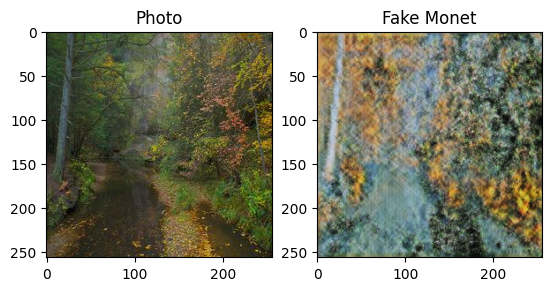

In [14]:
import matplotlib.pyplot as plt

sample_photo = next(iter(photos_ds.take(1)))
fake_monet = generator(sample_photo, training=False)

plt.subplot(1,2,1)
plt.title("Photo")
plt.imshow((sample_photo[0].numpy()+1)/2)

plt.subplot(1,2,2)
plt.title("Fake Monet")
plt.imshow((fake_monet[0].numpy()+1)/2)
plt.show()

# CycleGAN
The issue with traditional GAN is that it requires paired data - aka each input image needs a matching output image. This is not ideal for our setup as we have 7000 images and only 300 monet paintings.

CycleGAN learns to change images from one style to another in an unpaired fashion.

 GAN is paired, so if the input images are "types of shoes" and compared to a matching set of shoe images, it works great. 

 CycleGAN on the other hand, is better for tasks like changing the season in images, or in our case, portraying images in the style of a certain painter. 

 ### CycleGAN Architecture
 CycleGAN, unlike normal GAN, uses TWO generators G1 and G2.
 
 G1 transforms images from domain X (our photos) to domain Y (Artwork).
 
 G2 transforms images from domain Y back to domain X.

To regularize these mappings, CycleGAN uses 2 more loss functions as well as adversarial loss. 

1. Forward Cycle Consistency Loss - makes sure that when we go from G1 to G2 we get the original image.

2. Backward Cycle Consistency Loss = makes sure when we go from G2 to G1 we get the original image.

#### Generator Architecture
CycleGAN Generators have 3 sections:

1. An encoder that extracts features and compresses an image while increasing the # of channels.

2. A transformer that processes images based on input size.

3. A Decoder that up-samples the transformed image, restoring it to its original size.

#### Discriminator Architecture
The discriminator used in CycleGAN uses PatchGAN rather than a typical GAN discriminator. They differ in that a regular GAN discriminator looks at the entire image and gives out a score depending on the whole image, while PatchGAN breaks the image down into "patches" and outputs a grid where each value judges if that patch is real or fake.


In [9]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa


import matplotlib.pyplot as plt
import numpy as np

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)

AUTOTUNE = tf.data.experimental.AUTOTUNE
    
print(tf.__version__)

Number of replicas: 1
2.13.1


In [ ]:
import glob


LOCAL_PATH = r"C:/Users/diego/GradSchool/DeepLearningIntro/WeekFive/monet_tfrec"
MONET_FILENAMES = glob.glob(f"{LOCAL_PATH}/*.tfrec")



LOCAL_PATH = r"C:/Users/diego/GradSchool/DeepLearningIntro/WeekFive/photo_tfrec"
PHOTO_FILENAMES = glob.glob(f"{LOCAL_PATH}/*.tfrec")



['C:/Users/diego/GradSchool/DeepLearningIntro/WeekFive/monet_tfrec\\monet00-60.tfrec', 'C:/Users/diego/GradSchool/DeepLearningIntro/WeekFive/monet_tfrec\\monet04-60.tfrec', 'C:/Users/diego/GradSchool/DeepLearningIntro/WeekFive/monet_tfrec\\monet08-60.tfrec', 'C:/Users/diego/GradSchool/DeepLearningIntro/WeekFive/monet_tfrec\\monet12-60.tfrec', 'C:/Users/diego/GradSchool/DeepLearningIntro/WeekFive/monet_tfrec\\monet16-60.tfrec']
['C:/Users/diego/GradSchool/DeepLearningIntro/WeekFive/photo_tfrec\\photo00-352.tfrec', 'C:/Users/diego/GradSchool/DeepLearningIntro/WeekFive/photo_tfrec\\photo01-352.tfrec', 'C:/Users/diego/GradSchool/DeepLearningIntro/WeekFive/photo_tfrec\\photo02-352.tfrec', 'C:/Users/diego/GradSchool/DeepLearningIntro/WeekFive/photo_tfrec\\photo03-352.tfrec', 'C:/Users/diego/GradSchool/DeepLearningIntro/WeekFive/photo_tfrec\\photo04-352.tfrec', 'C:/Users/diego/GradSchool/DeepLearningIntro/WeekFive/photo_tfrec\\photo05-352.tfrec', 'C:/Users/diego/GradSchool/DeepLearningIntro/W

In [16]:
IMAGE_SIZE = [256, 256]

def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = (tf.cast(image, tf.float32) / 127.5) - 1
    image = tf.reshape(image, [*IMAGE_SIZE, 3])
    return image

def read_tfrecord(example):
    tfrecord_format = {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example['image'])
    return image

In [17]:
def load_dataset(filenames, labeled=True, ordered=False):
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTOTUNE)
    return dataset

In [18]:
monet_ds = load_dataset(MONET_FILENAMES, labeled=True).batch(1)
photo_ds = load_dataset(PHOTO_FILENAMES, labeled=True).batch(1)

In [19]:
OUTPUT_CHANNELS = 3

def downsample(filters, size, apply_instancenorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    result = keras.Sequential()
    result.add(layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

    if apply_instancenorm:
        result.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_init))

    result.add(layers.LeakyReLU())

    return result

In [20]:
def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    result = keras.Sequential()
    result.add(layers.Conv2DTranspose(filters, size, strides=2,
                                      padding='same',
                                      kernel_initializer=initializer,
                                      use_bias=False))

    result.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_init))

    if apply_dropout:
        result.add(layers.Dropout(0.5))

    result.add(layers.ReLU())

    return result

In [21]:
def Generator():
    inputs = layers.Input(shape=[256,256,3])

    # bs = batch size
    down_stack = [
        downsample(64, 4, apply_instancenorm=False), # (bs, 128, 128, 64)
        downsample(128, 4), # (bs, 64, 64, 128)
        downsample(256, 4), # (bs, 32, 32, 256)
        downsample(512, 4), # (bs, 16, 16, 512)
        downsample(512, 4), # (bs, 8, 8, 512)
        downsample(512, 4), # (bs, 4, 4, 512)
        downsample(512, 4), # (bs, 2, 2, 512)
        downsample(512, 4), # (bs, 1, 1, 512)
    ]

    up_stack = [
        upsample(512, 4, apply_dropout=True), # (bs, 2, 2, 1024)
        upsample(512, 4, apply_dropout=True), # (bs, 4, 4, 1024)
        upsample(512, 4, apply_dropout=True), # (bs, 8, 8, 1024)
        upsample(512, 4), # (bs, 16, 16, 1024)
        upsample(256, 4), # (bs, 32, 32, 512)
        upsample(128, 4), # (bs, 64, 64, 256)
        upsample(64, 4), # (bs, 128, 128, 128)
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                  strides=2,
                                  padding='same',
                                  kernel_initializer=initializer,
                                  activation='tanh') # (bs, 256, 256, 3)

    x = inputs

    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = layers.Concatenate()([x, skip])

    x = last(x)

    return keras.Model(inputs=inputs, outputs=x)

In [22]:
def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    inp = layers.Input(shape=[256, 256, 3], name='input_image')

    x = inp

    down1 = downsample(64, 4, False)(x) # (bs, 128, 128, 64)
    down2 = downsample(128, 4)(down1) # (bs, 64, 64, 128)
    down3 = downsample(256, 4)(down2) # (bs, 32, 32, 256)

    zero_pad1 = layers.ZeroPadding2D()(down3) # (bs, 34, 34, 256)
    conv = layers.Conv2D(512, 4, strides=1,
                         kernel_initializer=initializer,
                         use_bias=False)(zero_pad1) # (bs, 31, 31, 512)

    norm1 = tfa.layers.InstanceNormalization(gamma_initializer=gamma_init)(conv)

    leaky_relu = layers.LeakyReLU()(norm1)

    zero_pad2 = layers.ZeroPadding2D()(leaky_relu) # (bs, 33, 33, 512)

    last = layers.Conv2D(1, 4, strides=1,
                         kernel_initializer=initializer)(zero_pad2) # (bs, 30, 30, 1)

    return tf.keras.Model(inputs=inp, outputs=last)

In [23]:
with strategy.scope():
    monet_generator = Generator() # transforms photos to Monet-esque paintings
    photo_generator = Generator() # transforms Monet paintings to be more like photos

    monet_discriminator = Discriminator() # differentiates real Monet paintings and generated Monet paintings
    photo_discriminator = Discriminator() # differentiates real photos and generated photos

In [24]:
class CycleGan(keras.Model):
    def __init__(
        self,
        monet_generator,
        photo_generator,
        monet_discriminator,
        photo_discriminator,
        lambda_cycle=10,
    ):
        super(CycleGan, self).__init__()
        self.m_gen = monet_generator
        self.p_gen = photo_generator
        self.m_disc = monet_discriminator
        self.p_disc = photo_discriminator
        self.lambda_cycle = lambda_cycle
        
    def compile(
        self,
        m_gen_optimizer,
        p_gen_optimizer,
        m_disc_optimizer,
        p_disc_optimizer,
        gen_loss_fn,
        disc_loss_fn,
        cycle_loss_fn,
        identity_loss_fn
    ):
        super(CycleGan, self).compile()
        self.m_gen_optimizer = m_gen_optimizer
        self.p_gen_optimizer = p_gen_optimizer
        self.m_disc_optimizer = m_disc_optimizer
        self.p_disc_optimizer = p_disc_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn
        
    def train_step(self, batch_data):
        real_monet, real_photo = batch_data
        
        with tf.GradientTape(persistent=True) as tape:
            # photo to monet back to photo
            fake_monet = self.m_gen(real_photo, training=True)
            cycled_photo = self.p_gen(fake_monet, training=True)

            # monet to photo back to monet
            fake_photo = self.p_gen(real_monet, training=True)
            cycled_monet = self.m_gen(fake_photo, training=True)

            # generating itself
            same_monet = self.m_gen(real_monet, training=True)
            same_photo = self.p_gen(real_photo, training=True)

            # discriminator used to check, inputing real images
            disc_real_monet = self.m_disc(real_monet, training=True)
            disc_real_photo = self.p_disc(real_photo, training=True)

            # discriminator used to check, inputing fake images
            disc_fake_monet = self.m_disc(fake_monet, training=True)
            disc_fake_photo = self.p_disc(fake_photo, training=True)

            # evaluates generator loss
            monet_gen_loss = self.gen_loss_fn(disc_fake_monet)
            photo_gen_loss = self.gen_loss_fn(disc_fake_photo)

            # evaluates total cycle consistency loss
            total_cycle_loss = self.cycle_loss_fn(real_monet, cycled_monet, self.lambda_cycle) + self.cycle_loss_fn(real_photo, cycled_photo, self.lambda_cycle)

            # evaluates total generator loss
            total_monet_gen_loss = monet_gen_loss + total_cycle_loss + self.identity_loss_fn(real_monet, same_monet, self.lambda_cycle)
            total_photo_gen_loss = photo_gen_loss + total_cycle_loss + self.identity_loss_fn(real_photo, same_photo, self.lambda_cycle)

            # evaluates discriminator loss
            monet_disc_loss = self.disc_loss_fn(disc_real_monet, disc_fake_monet)
            photo_disc_loss = self.disc_loss_fn(disc_real_photo, disc_fake_photo)

        # Calculate the gradients for generator and discriminator
        monet_generator_gradients = tape.gradient(total_monet_gen_loss,
                                                  self.m_gen.trainable_variables)
        photo_generator_gradients = tape.gradient(total_photo_gen_loss,
                                                  self.p_gen.trainable_variables)

        monet_discriminator_gradients = tape.gradient(monet_disc_loss,
                                                      self.m_disc.trainable_variables)
        photo_discriminator_gradients = tape.gradient(photo_disc_loss,
                                                      self.p_disc.trainable_variables)

        # Apply the gradients to the optimizer
        self.m_gen_optimizer.apply_gradients(zip(monet_generator_gradients,
                                                 self.m_gen.trainable_variables))

        self.p_gen_optimizer.apply_gradients(zip(photo_generator_gradients,
                                                 self.p_gen.trainable_variables))

        self.m_disc_optimizer.apply_gradients(zip(monet_discriminator_gradients,
                                                  self.m_disc.trainable_variables))

        self.p_disc_optimizer.apply_gradients(zip(photo_discriminator_gradients,
                                                  self.p_disc.trainable_variables))
        
        return {
            "monet_gen_loss": total_monet_gen_loss,
            "photo_gen_loss": total_photo_gen_loss,
            "monet_disc_loss": monet_disc_loss,
            "photo_disc_loss": photo_disc_loss
        }

In [25]:
with strategy.scope():
    def discriminator_loss(real, generated):
        real_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(real), real)

        generated_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.zeros_like(generated), generated)

        total_disc_loss = real_loss + generated_loss

        return total_disc_loss * 0.5

In [26]:
with strategy.scope():
    def generator_loss(generated):
        return tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(generated), generated)

In [27]:
with strategy.scope():
    def calc_cycle_loss(real_image, cycled_image, LAMBDA):
        loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))

        return LAMBDA * loss1

In [28]:
with strategy.scope():
    def identity_loss(real_image, same_image, LAMBDA):
        loss = tf.reduce_mean(tf.abs(real_image - same_image))
        return LAMBDA * 0.5 * loss

In [29]:
with strategy.scope():
    monet_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    photo_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

    monet_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    photo_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [30]:
with strategy.scope():
    cycle_gan_model = CycleGan(
        monet_generator, photo_generator, monet_discriminator, photo_discriminator
    )

    cycle_gan_model.compile(
        m_gen_optimizer = monet_generator_optimizer,
        p_gen_optimizer = photo_generator_optimizer,
        m_disc_optimizer = monet_discriminator_optimizer,
        p_disc_optimizer = photo_discriminator_optimizer,
        gen_loss_fn = generator_loss,
        disc_loss_fn = discriminator_loss,
        cycle_loss_fn = calc_cycle_loss,
        identity_loss_fn = identity_loss
    )

In [1]:
cycle_gan_model.fit(
    tf.data.Dataset.zip((monet_ds, photo_ds)),
    epochs=25
)

NameError: name 'cycle_gan_model' is not defined

# Discussion and Conclusion
While CycleGAN is interesting in concept, the fact that it requires 4 total models (2 generators and 2 discriminators) adds drastically to the processing time. 
Upon my calculations, it would take my machine 7 days straight to process all 7000 images for only 25 epochs and unfortunately I simply do not have the time to delve deeper.